In [22]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import json


import matplotlib.colorbar as mplcb
import matplotlib.cm as mplcm
from scipy.spatial.distance import pdist, squareform
import ripser

#sc.logging.print_header()
#sc.settings.verbosity = 3

In [12]:
def read_visium(path, library_id='stx'):
    r"""Read 10x-Genomics-formatted visum dataset.
    """
    path = Path(path)
    matrix_path = path / "filtered_feature_bc_matrix/"
    adata = sc.read_10x_mtx(matrix_path)

    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()

    tissue_positions_file = (
        path / "spatial/tissue_positions.csv"
        if (path / "spatial/tissue_positions.csv").exists()
        else path / "spatial/tissue_positions_list.csv"
    )
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path / "spatial/scalefactors_json.json",
        hires_image=path / "spatial/tissue_hires_image.png",
        lowres_image=path / "spatial/tissue_lowres_image.png",
    )

    # check if files exists, continue if images are missing
    for f in files.values():
        if not f.exists():
            if any(x in str(f) for x in ["tissue_hires_image", "tissue_lowres_image"]):
                logg.warning(
                    f"You seem to be missing an image file.\nCould not find {f}."
                )
            else:
                msg = f"Could not find {f}"
                raise OSError(msg)

    adata.uns["spatial"][library_id]["images"] = dict()

    for res in ["hires", "lowres"]:
        image_path = str(files[f"{res}_image"])
        adata.uns["spatial"][library_id]["images"][res] = imread(image_path)
      
        # read json scalefactors
        adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
            files["scalefactors_json_file"].read_bytes()
        )

        # read coordinates
        positions = pd.read_csv(
            files["tissue_positions_file"],
            header=0 if tissue_positions_file.name == "tissue_positions.csv" else None,
            index_col=0,
        )
        positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]

        adata.obs = pd.merge(
            adata.obs,
            positions,
            how='left',
            left_index=True,
            right_index=True,
        )

        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )

    return adata

fpath = "/HFD14/ST/"
current_directory = os.getcwd()+fpath
print(current_directory)
adata = read_visium(current_directory)
sc.logging.print_memory_usage()
adata

/Users/wenyiye/math 547 /HFD14/ST/
Memory usage: current 0.16 GB, difference -0.59 GB


AnnData object with n_obs × n_vars = 1994 × 31053
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'in_tissue_y', 'array_row_y', 'array_col_y'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
# simple preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 1994 × 31053
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'in_tissue_y', 'array_row_y', 'array_col_y'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

/var/folders/6g/__5vs7k9339d_y5ztlb880wm0000gn/T/ipykernel_43128/3498164135.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


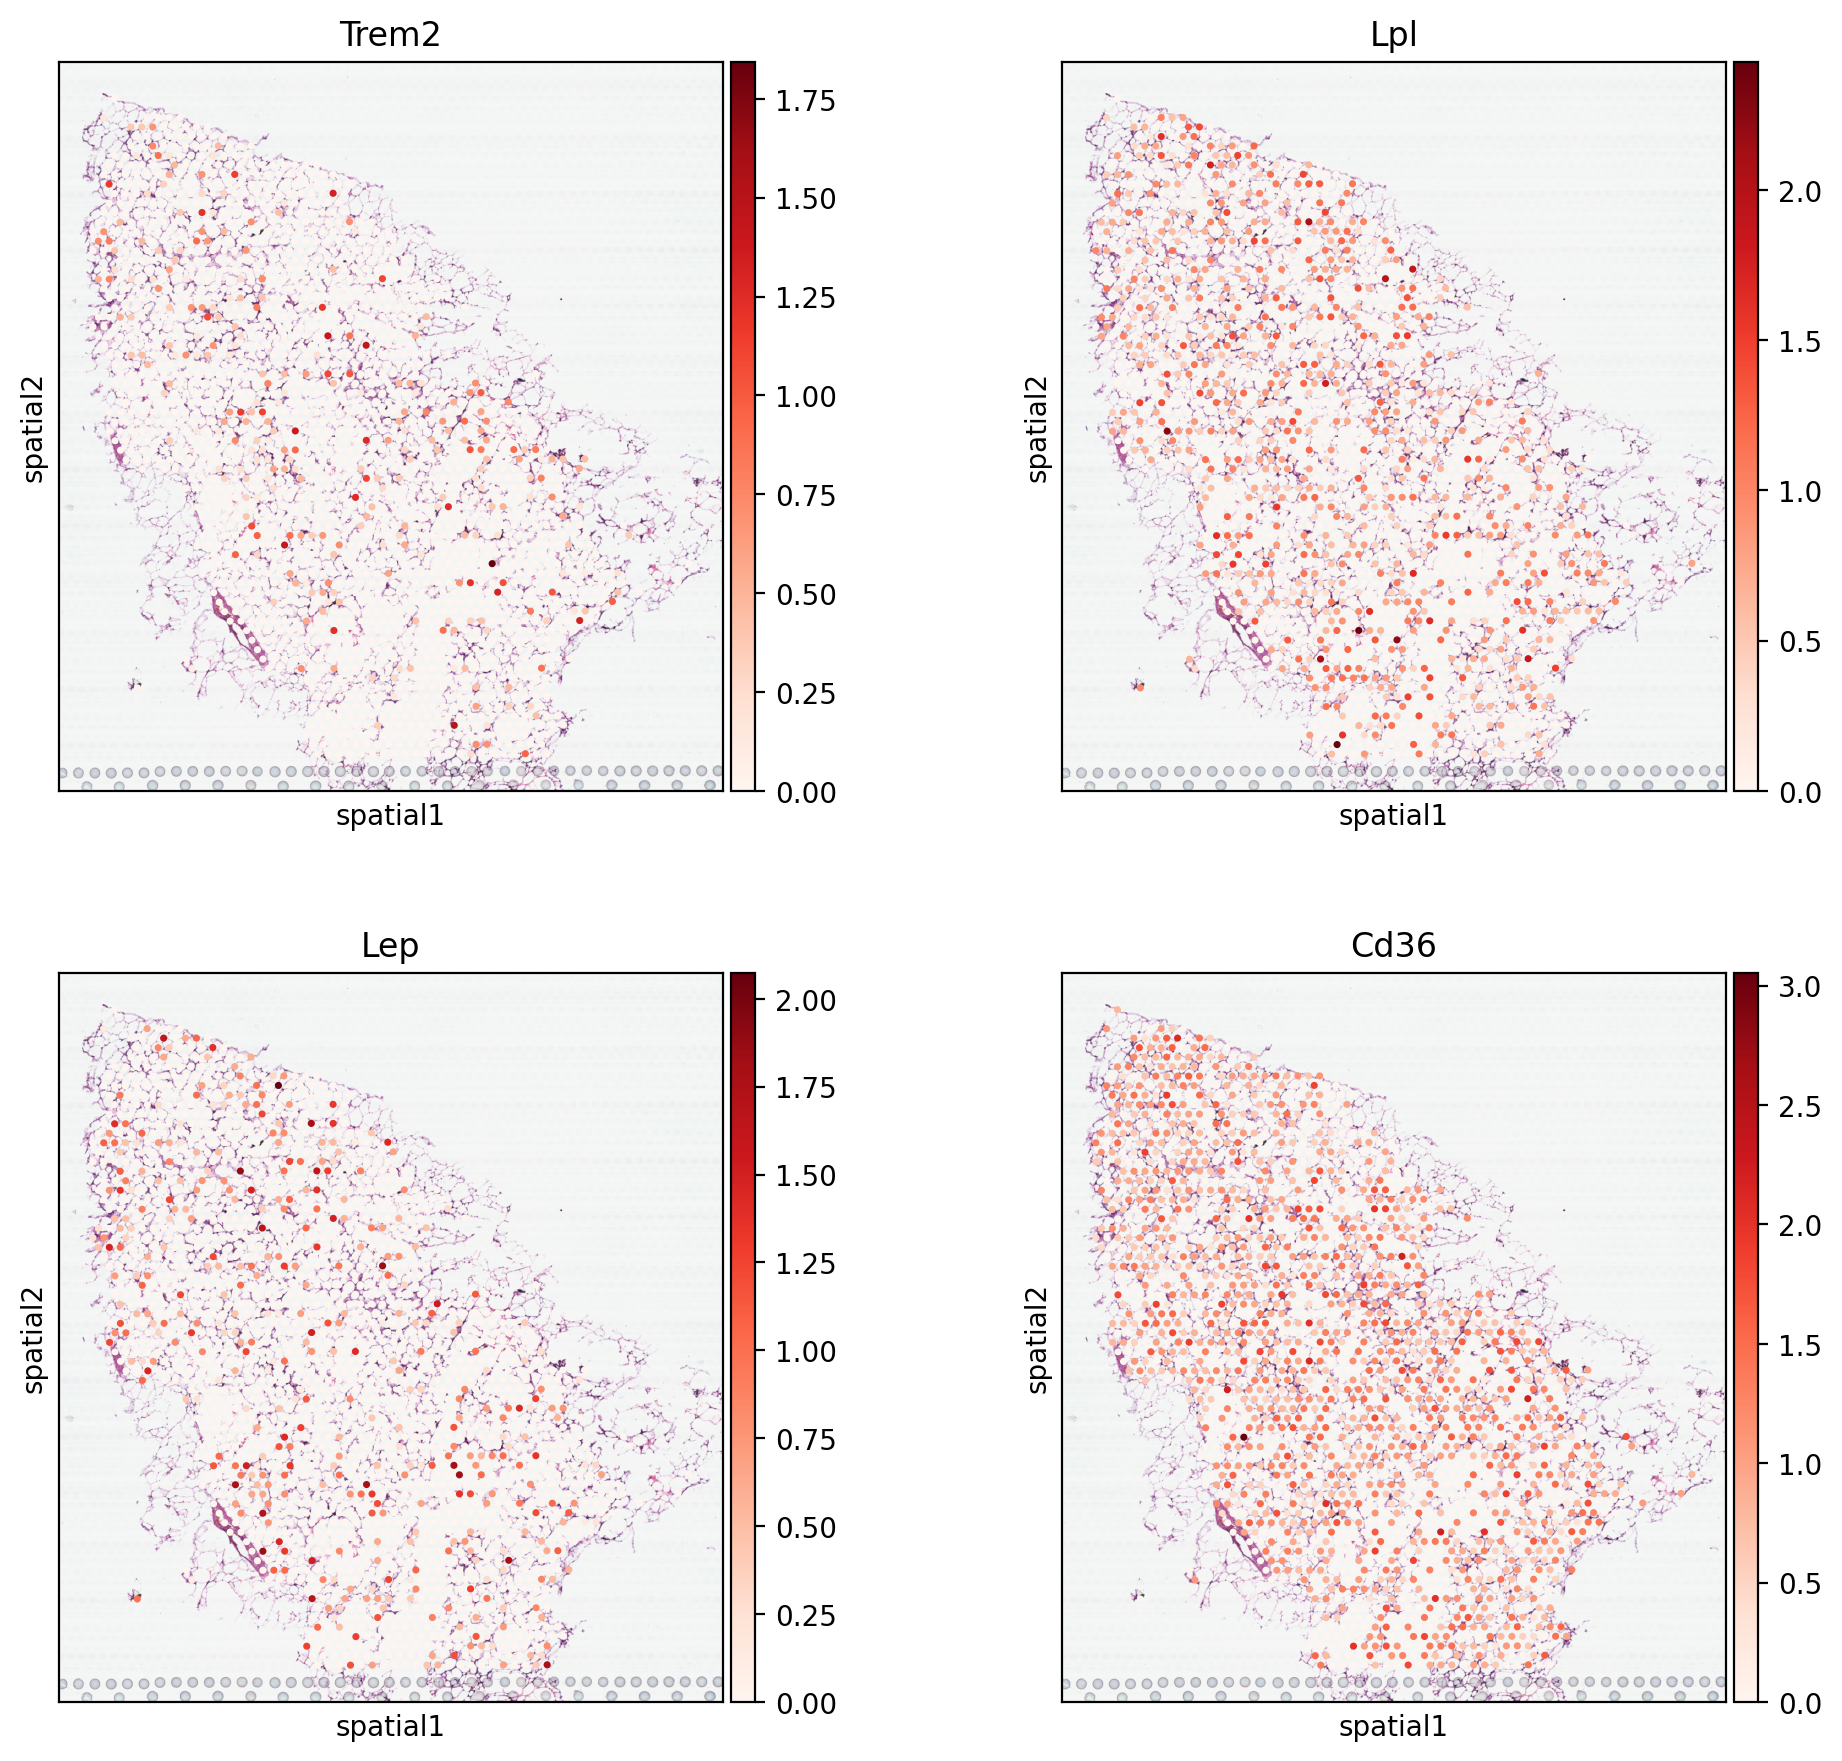

In [14]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5
sc.pl.spatial(
    adata, img_key="hires", 
    color=["Trem2", 'Lpl', 'Lep', 'Cd36'],
    color_map='Reds',
    ncols=2,
)

# Load the points for a single gene

In [31]:
gene = 'Trem2'

df = adata[:, gene].to_df()
print(f"{df.shape=}")

coords = pd.DataFrame(adata.obsm['spatial'], index=df.index, columns=['x', 'y'])
print(f"{coords.shape=}")

# merge in the coordinates
df = pd.merge(
    df, 
    coords, 
    how='left', 
    left_index=True, 
    right_index=True,
)

df.head()

df.shape=(1994, 1)
coords.shape=(1994, 2)


,Trem2,x,y
AAACATTTCCCGGATT-1,0.0,23202,27803
AAACCGGGTAGGTACC-1,0.0,9528,21281
AAACCGTTCGTCCAGG-1,0.0,12306,24722
AAACCTAAGCAGCCGG-1,0.0,20432,29186
AAACCTCATGAAGTTG-1,0.0,7743,19562


In [32]:
#Q1
df_nonzero = df[df[gene] > 0]
coords_nonzero = coords.loc[df_nonzero.index]

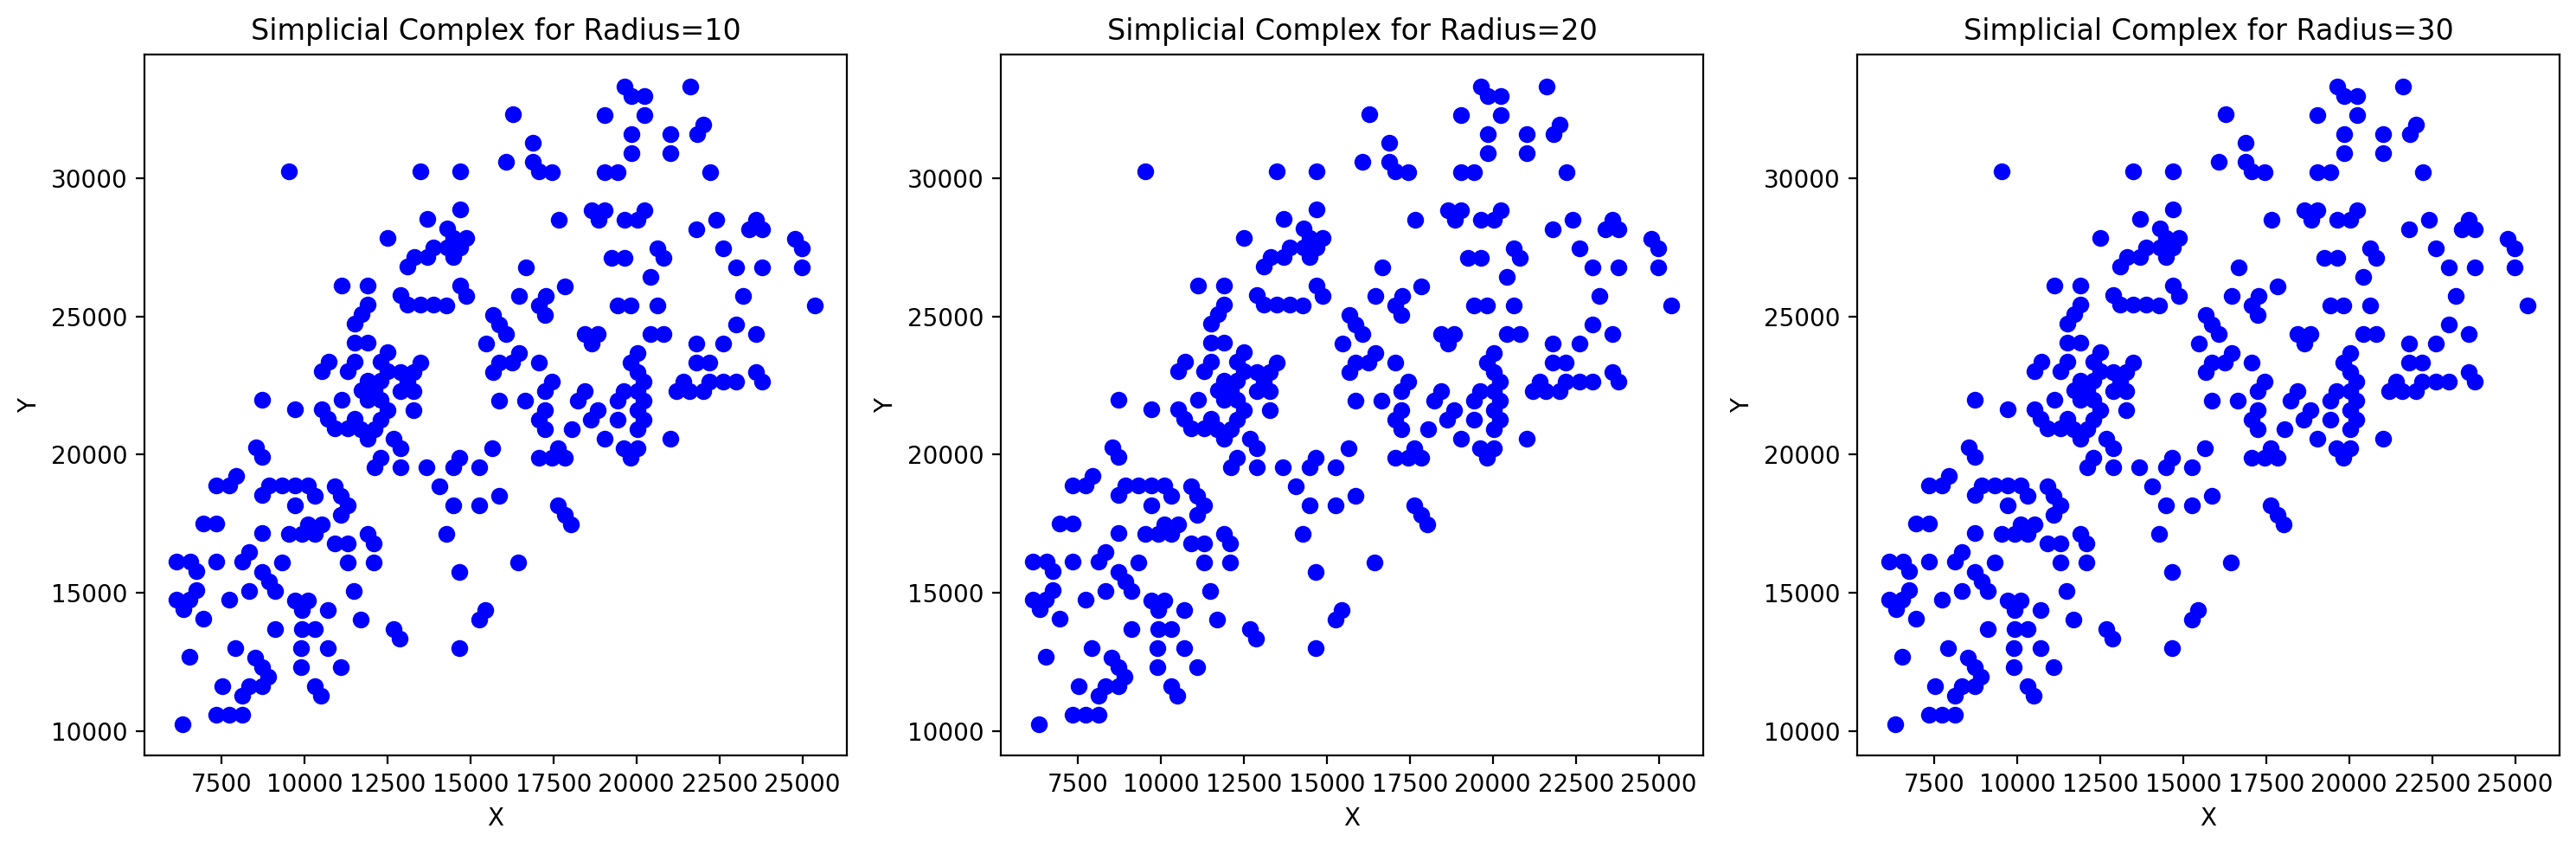

In [33]:
# Function to compute the simplicial complex for a given radius
def compute_simplicial_complex(coords, radius):
    distance_matrix = squareform(pdist(coords, metric='euclidean'))
    # Build adjacency matrix based on radius
    adjacency_matrix = (distance_matrix <= radius).astype(int)
    
    # Use ripser to compute the simplicial complex
    result = ripser.ripser(adjacency_matrix,distance_matrix=True)
    return result
# List of different radii
radii = [10, 20, 30]

# Plot simplicial complexes for different radii
fig, axes = plt.subplots(1, len(radii), figsize=(15, 5))

for ax, radius in zip(axes, radii):
    result = compute_simplicial_complex(coords_nonzero, radius)
    
    # Plot the simplicial complex
    ax.scatter(coords_nonzero['x'], coords_nonzero['y'], c='blue', label=f'Radius={radius}')
    ax.set_title(f'Simplicial Complex for Radius={radius}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

Filtered coordinates with expression >= 1.0: (30, 2)


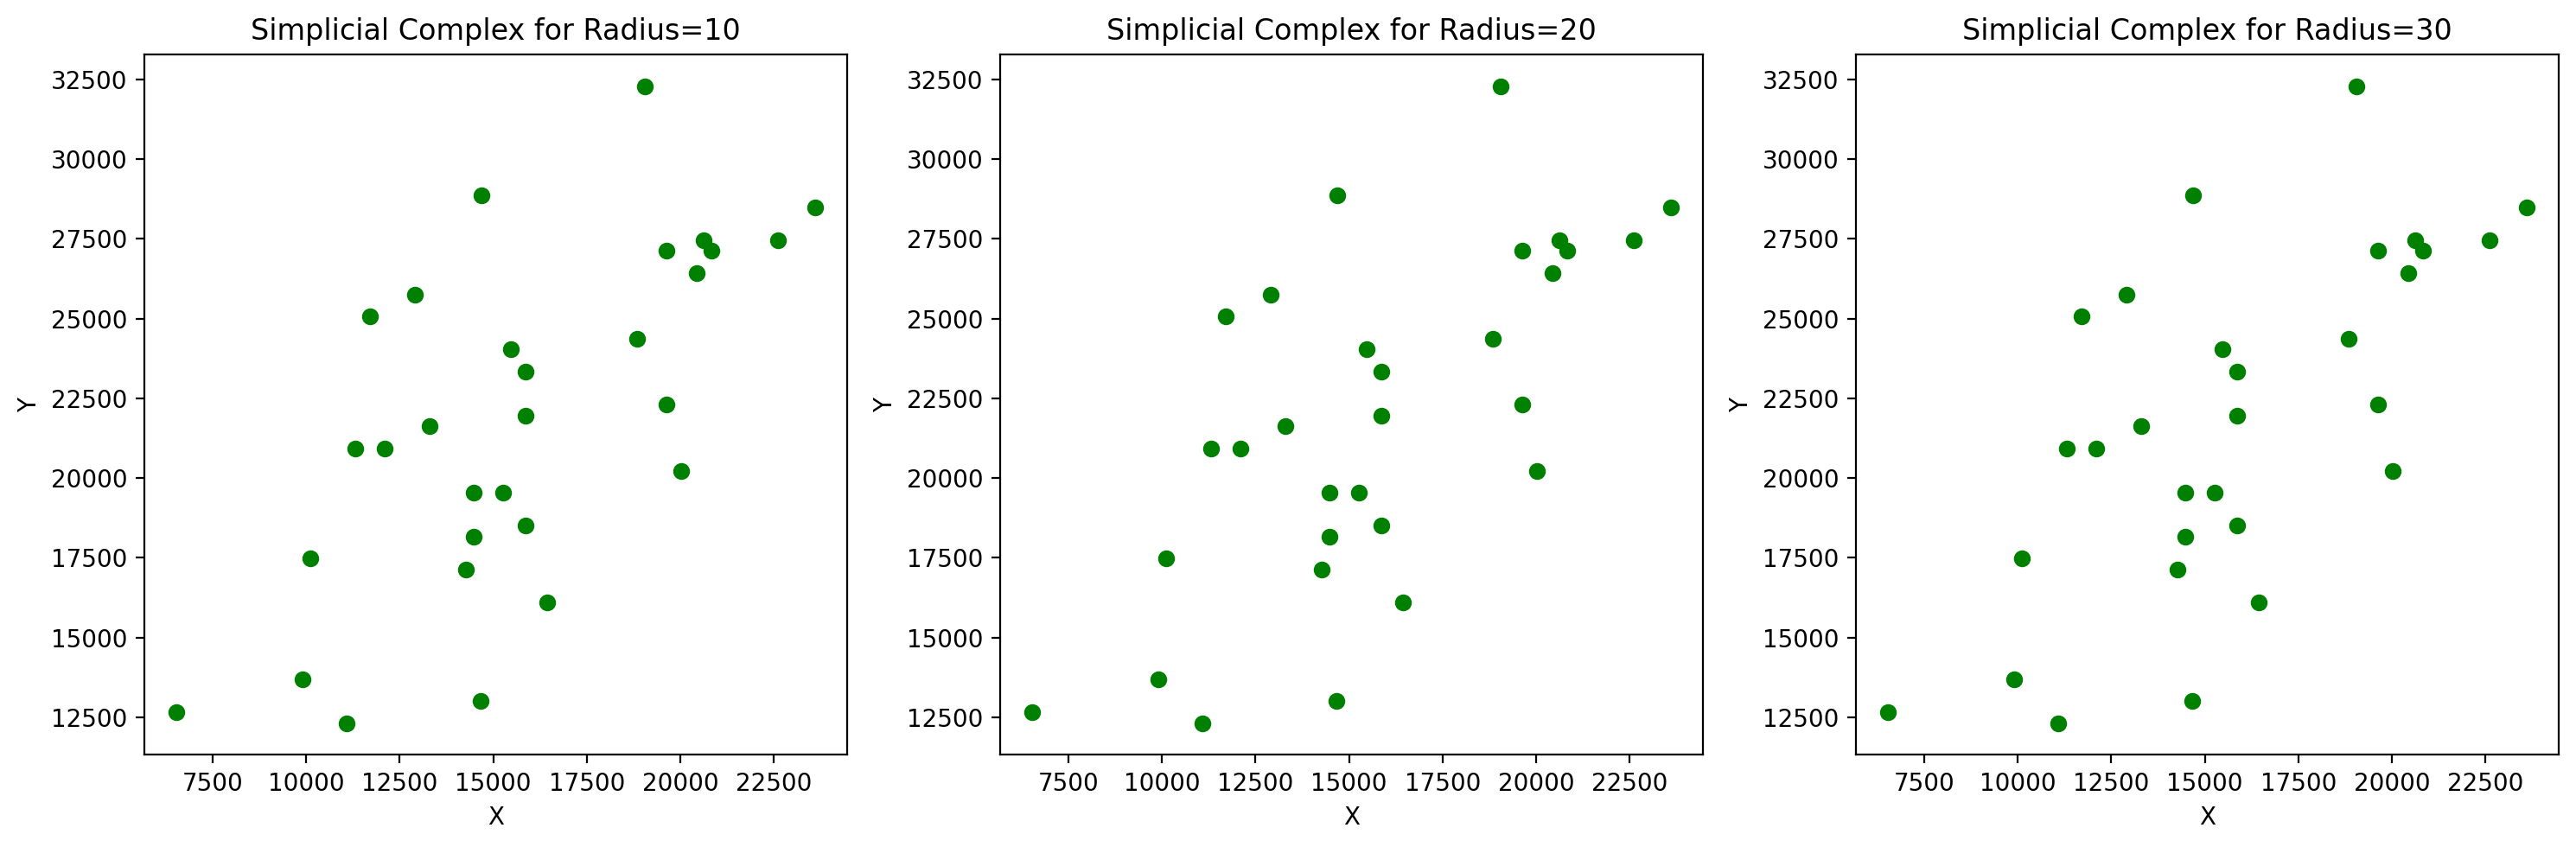

In [34]:
# Apply a threshold to the gene expression (you can modify the threshold as needed)
threshold = 1.0  # Example threshold
df_thresholded = df[df[gene] >= threshold]
coords_thresholded = coords.loc[df_thresholded.index]

print(f"Filtered coordinates with expression >= {threshold}: {coords_thresholded.shape}")
# Plot simplicial complexes for different radii with thresholded expression
fig, axes = plt.subplots(1, len(radii), figsize=(15, 5))

for ax, radius in zip(axes, radii):
    result = compute_simplicial_complex(coords_thresholded, radius)
    
    # Plot the simplicial complex
    ax.scatter(coords_thresholded['x'], coords_thresholded['y'], c='green', label=f'Radius={radius}')
    ax.set_title(f'Simplicial Complex for Radius={radius}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()


In [35]:
genes = ['Trem2', 'Lpl', 'Lep', 'Cd36']
threshold = 1.0  # Modify threshold as needed

# Filter genes and coordinates for thresholded expression
filtered_coords = {}
for gene in genes:
    df_gene = adata[:, gene].to_df()
    df_filtered = df_gene[df_gene[gene] >= threshold]
    coords_filtered = coords.loc[df_filtered.index]
    filtered_coords[gene] = coords_filtered

# Check the results
print(f"Filtered coordinates for genes: {filtered_coords}")


Filtered coordinates for genes: {'Trem2':                         x      y
ACATCGGTCAGCCGCG-1  11309  20934
CACCCGGTTTGTGACT-1  11713  25067
CAGGATATATCGTTGT-1  15865  21959
CATGAGATGCACTCTC-1  19637  27120
CCGCTCTTCCGAACTA-1  23599  28491
CCTATACCGTCCTGTC-1  12902  25754
CTACTGCCACCTGACC-1  16449  16101
CTTTGCATCGCTCTTG-1  22607  27460
GAAATGGCGGTGTTAG-1  14273  17139
GAAGCGTGAGGAATTT-1  15859  18514
GATAGGTAACGTTGAC-1  15868  23337
GATATGAGACACTAAC-1  20020  20229
GATGCGTCCTGCATTC-1  15267  19549
GATGTTTGTGCGAGAT-1   9910  13701
GCGCGTCATTGGTACA-1  20427  26430
GCGCTATGCCGAGGCA-1  13291  21619
GCGTCGTAACATGGTC-1  19052  32289
GCTCTTTCCGCTAGTG-1  14690  28852
GCTGCTACTGCGTAGC-1  18840  24366
GCTGGCATATTCACCT-1  10115  17491
GGATTGCTGTGACTCC-1  20627  27463
GGTATTGCCGAGTTTA-1  14473  18172
GGTGAGATGCAGATAA-1  11096  12321
GTGGTGGCCAAGTGAA-1  19628  22297
GTTCGCCATAAGTGCC-1  14475  19550
TACAGAAACGGTGGGC-1  20825  27118
TAGCTCGCCTGATAAC-1  15473  24027
TCCTAGCAAAGAAGCT-1  12101  20932
T

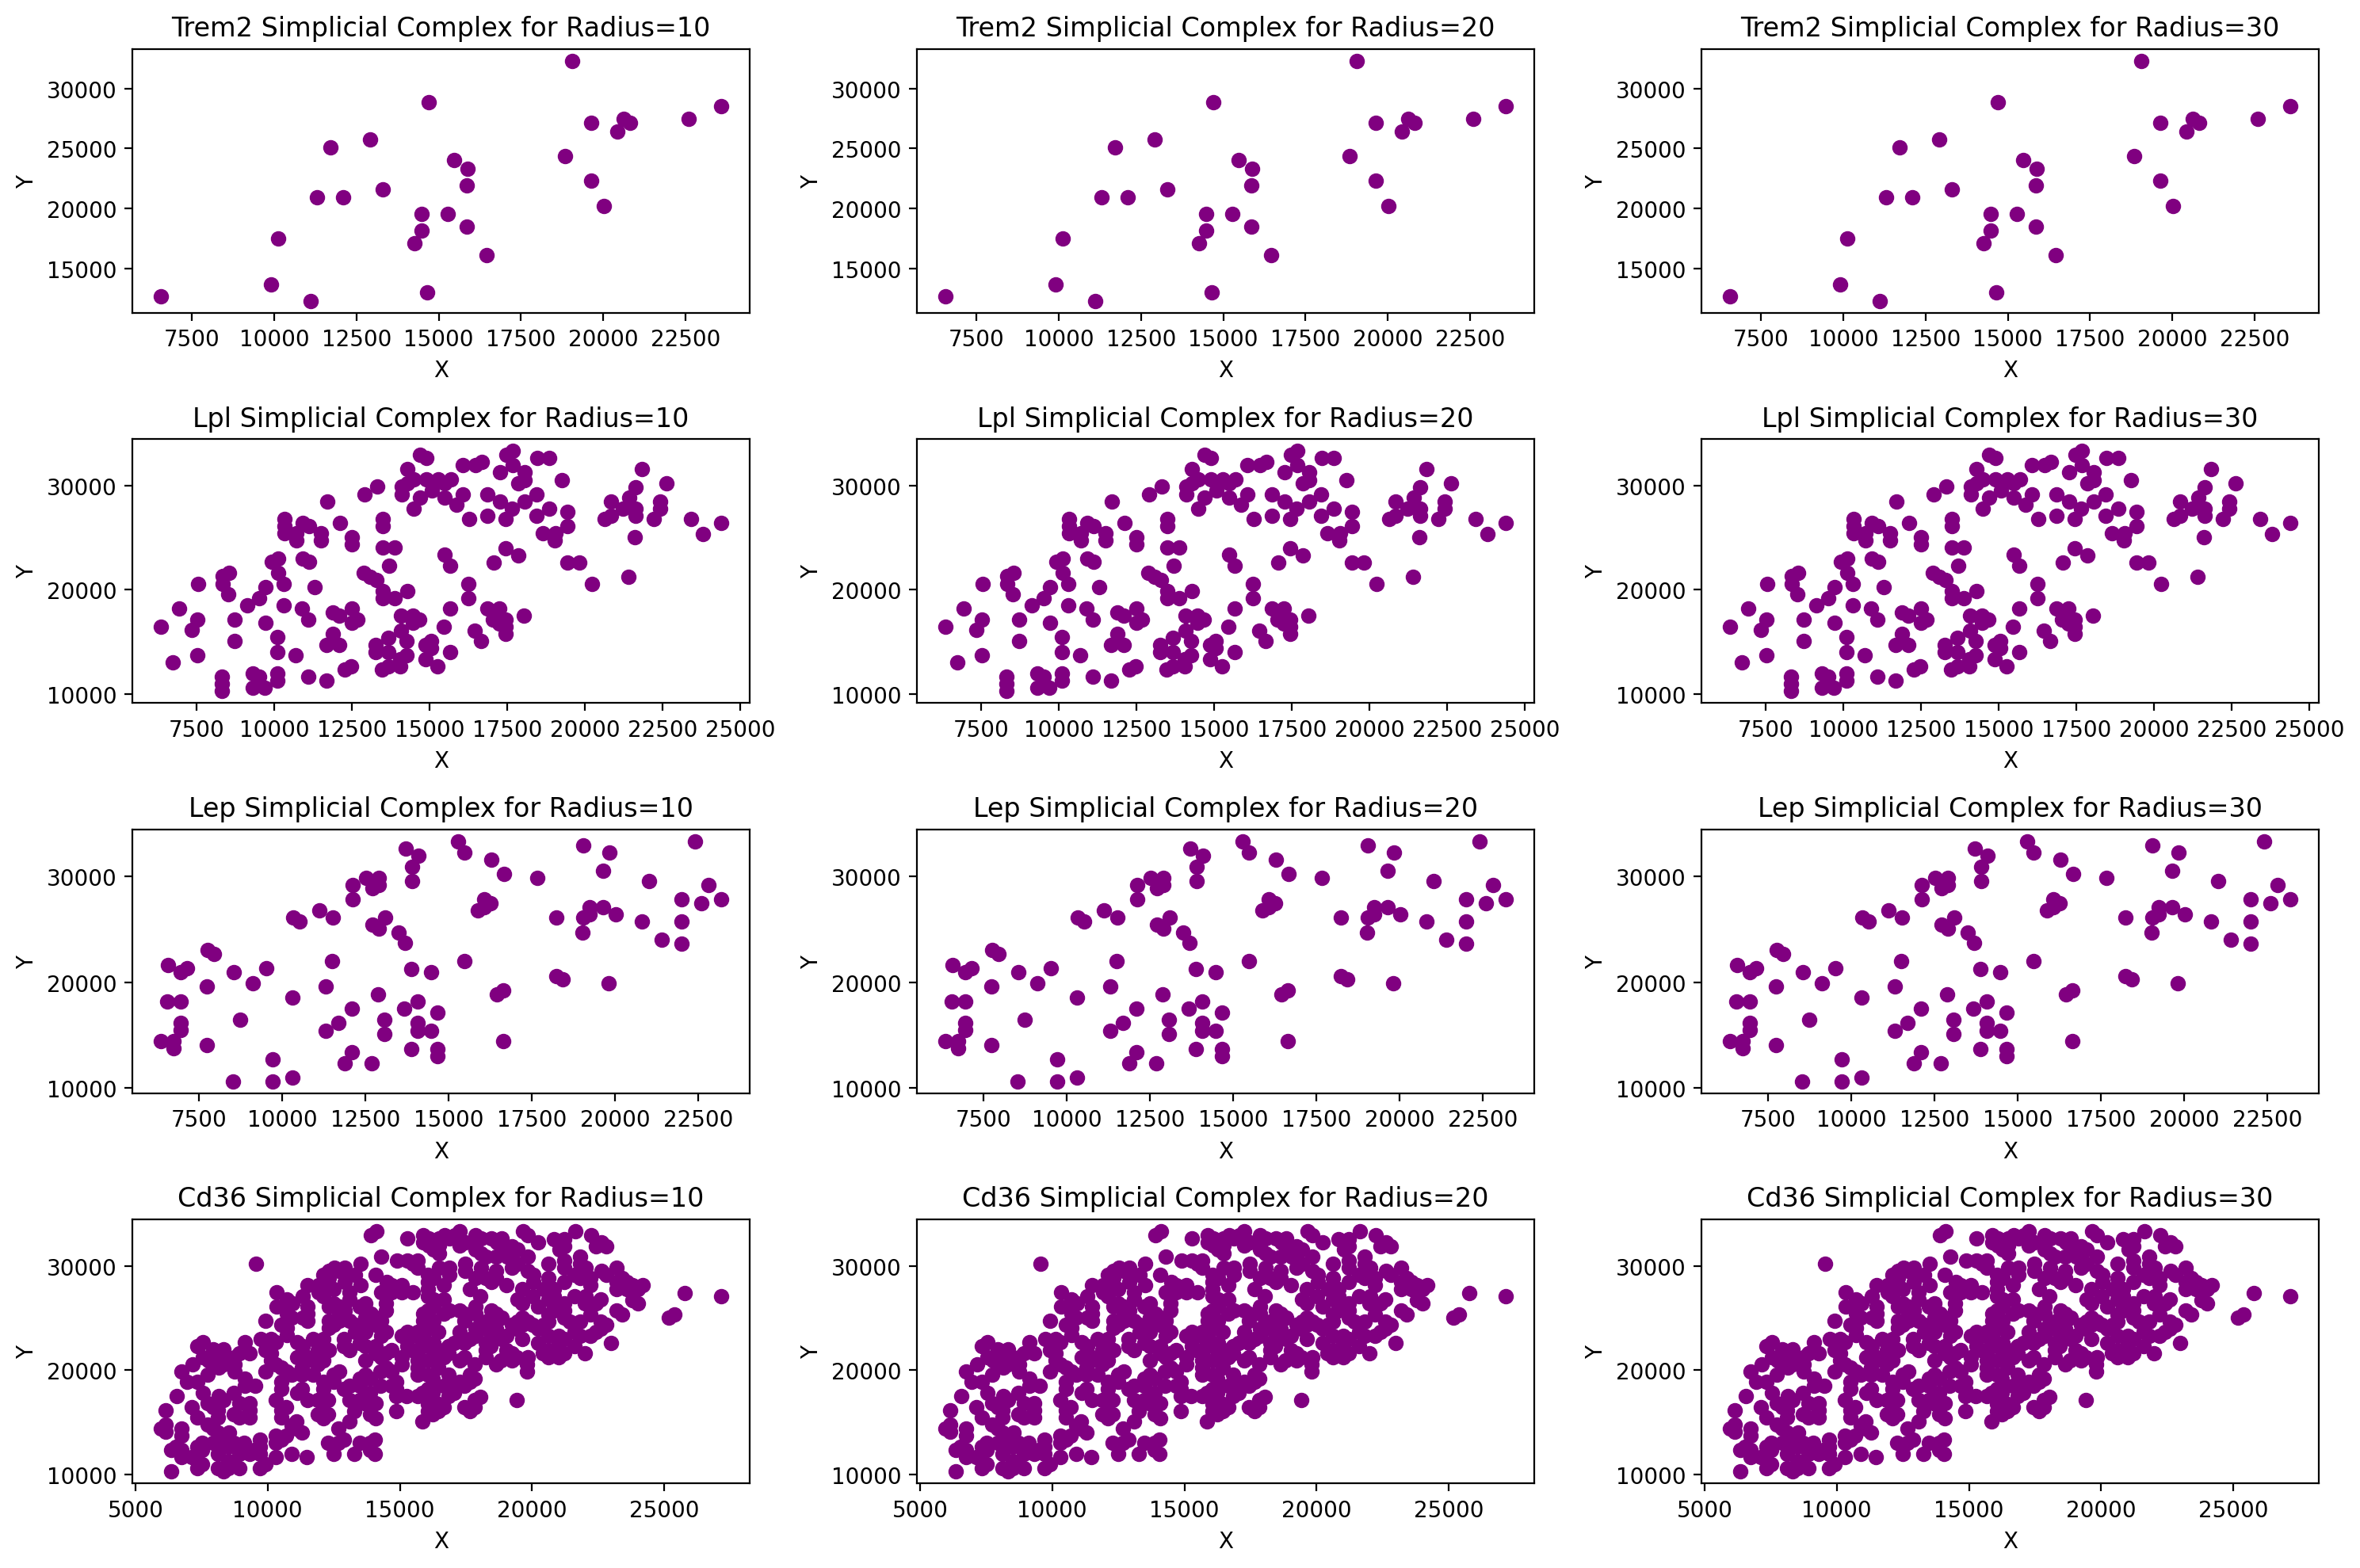

In [36]:
# Plot simplicial complexes for multiple genes and different radii
fig, axes = plt.subplots(len(genes), len(radii), figsize=(15, 10))

for i, gene in enumerate(genes):
    for j, radius in enumerate(radii):
        coords_gene = filtered_coords[gene]
        result = compute_simplicial_complex(coords_gene, radius)
        
        ax = axes[i, j]
        ax.scatter(coords_gene['x'], coords_gene['y'], c='purple', label=f'{gene} Radius={radius}')
        ax.set_title(f'{gene} Simplicial Complex for Radius={radius}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

plt.tight_layout()
plt.savefig('/Users/wenyiye/Desktop/your_plot.png', dpi=300)
plt.show()


/var/folders/6g/__5vs7k9339d_y5ztlb880wm0000gn/T/ipykernel_43128/3173582000.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


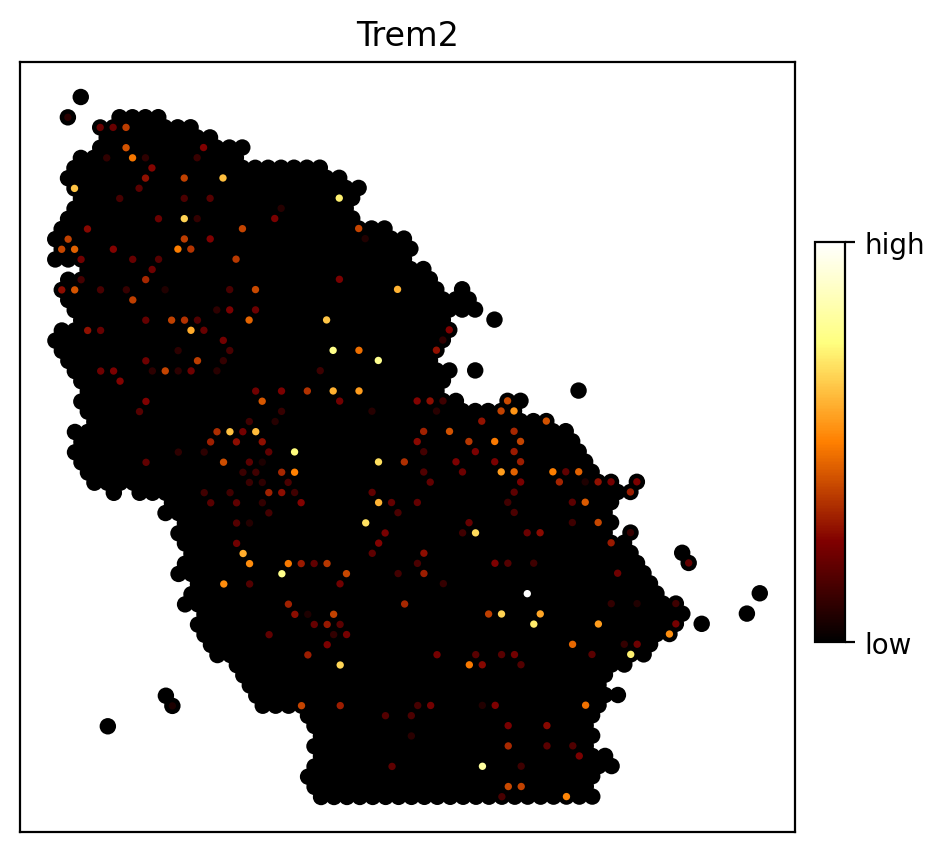

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

cmap = 'afmhot'

sns.scatterplot(
    data=df,
    x='x',
    y='y',
    c='k',
    palette='Reds',
    s=35,
    ec='none'
)

scatter_plot = sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue=gene,
    ec='none',
    palette=cmap,
    s=7,
    legend=False,
)

plt.gca().invert_yaxis()
plt.yticks([])
plt.xticks([])
plt.ylabel("")
plt.xlabel("")
plt.title(gene)

norm = plt.Normalize(df[gene].min(), df[gene].max())
sm = mplcm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) # need to set array for colorbar to work

cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.03, 0.4])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')

cbar.set_ticks([df[gene].min(), df[gene].max()])
cbar.set_ticklabels(['low', 'high'])

plt.show()